# RANLP 2025 Practical — Prompting & Fine‑tuning Large Language Models
**Instructor:** Msc. Ernesto Luis Estevanell‑Valladares

Welcome. Today we’ll teach language models to do two things people ask for every day: **answer questions** and **translate text**. Think of the little answer boxes you see in search, or the moment a translation unlocks a message. We’ll start small, compare simple prompting decisions, measure what we get, and then fine‑tune compact models to do better. As we go, we’ll explain ideas in plain language so the code never feels mysterious.

This practical stands on its own. You’ll meet the tasks (Question Answering with **SQuAD** and English→Spanish translation with an **OPUS** subset), the models (**GPT‑2** and **T5**), and a workflow you can reuse: look at a few examples, set sensible length limits from the data, try a clear prompt with a basic decoding choice, measure quality, and then fine‑tune and compare again.

## How we’ll work

We will walk the same path twice. First on **question answering** with SQuAD, then on **translation** with OPUS. Each time we’ll skim a few examples, choose practical length limits, try a clear prompt and a basic decoding setting, measure, and then fine‑tune a small model and check the result again.


### Why these architectures make sense for today’s tasks

Question answering and translation both require writing text *conditioned* on something: a passage + question, or a source sentence. A decoder‑only model like GPT‑2 conditions on that information by putting it in the same sequence it continues. An encoder–decoder like T5 separates the “read” and “write” steps: the encoder builds a representation of the input, and the decoder generates while looking back at it. You’ll see this difference reflected in how we set up inputs for each model in the code that follows.


## The datasets

**SQuAD** is a collection of questions written about Wikipedia articles, each with an answer found in the text. It’s a standard way to check whether a system can read and reply accurately to a question.

**OPUS** is a large, open collection of translated sentence pairs. **OPUS‑100** is an English‑centric slice covering many languages; we’ll work with a small English→Spanish subset so runs stay fast while still feeling realistic.


### A quick note on runtime

To keep things comfortable on classroom GPUs, we’ll use small subsets. Treat absolute scores as illustrative; focus on **relative** improvements as we change prompts, decoding, and fine‑tune the models.


### Small helpers you’ll see in the code

We use a few tiny utilities to keep the notebook readable. `human_time` prints friendly timings, `peek` shows a tidy slice of a dataset without flooding the screen, and `clear_memory` frees GPU memory when we swap models. Nothing magical—just quality‑of‑life tools.


In [1]:
#%pip uninstall -q -y torch torchvision torchaudio transformers datasets evaluate sacrebleu sentencepiece accelerate trl langdetect langcodes pandas matplotlib tf-keras peft
#%pip uninstall -q -y tensorflow keras tf-keras

In [2]:
#%pip install -q torch torchaudio --index-url https://download.pytorch.org/whl/cu126
#%pip install -q transformers datasets evaluate sacrebleu sentencepiece trl langdetect accelerate>=0.21.0 peft langcodes pandas matplotlib


In [3]:
# ## Part 0 — Setup
import os, random, math, json, time, re
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, DatasetDict, Dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    set_seed,
)

# Visualization
import matplotlib.pyplot as plt

SEED = 42
set_seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [4]:
# %%
import gc

def human_time(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h:d}h {m:02d}m {s:02d}s"

def peek(ds: Dataset, n: int = 2):
    for i in range(n):
        print(json.dumps(ds[i], ensure_ascii=False, indent=2))

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    
print('Helpers ready.')

Helpers ready.


# Part A — Question Answering with SQuAD

Our goal is to have a model read a short passage and a question, then **write the answer**. SQuAD was designed with answers that appear in the passage, but here we treat it as a tiny generation task: read the passage and question, then produce the answer text. This keeps the approach consistent across models and makes evaluation straightforward.

In [5]:
# %%
squad = load_dataset('squad')
squad

squad_train = squad['train'].shuffle()
squad_validation = squad['validation'].shuffle()

Take a minute to skim a few SQuAD items. Notice where the answer lives in the passage and how long answers tend to be. Also watch for near‑miss phrases that could fool a word‑matching system. Make a quick guess for a safe upper bound on answer length—we’ll verify it next.

In [6]:
# %%
peek(squad_train)
peek(squad_validation)


{
  "id": "573173d8497a881900248f0c",
  "title": "Egypt",
  "context": "The Pew Forum on Religion & Public Life ranks Egypt as the fifth worst country in the world for religious freedom. The United States Commission on International Religious Freedom, a bipartisan independent agency of the US government, has placed Egypt on its watch list of countries that require close monitoring due to the nature and extent of violations of religious freedom engaged in or tolerated by the government. According to a 2010 Pew Global Attitudes survey, 84% of Egyptians polled supported the death penalty for those who leave Islam; 77% supported whippings and cutting off of hands for theft and robbery; and 82% support stoning a person who commits adultery.",
  "question": "What percentage of Egyptians polled support death penalty for those leaving Islam?",
  "answers": {
    "text": [
      "84%"
    ],
    "answer_start": [
      468
    ]
  }
}
{
  "id": "57277e815951b619008f8b52",
  "title": "Ann_Arbor,

Before generating anything, we’ll look at tokenized length distributions for inputs and answers. Choosing caps around the upper part of the distribution (roughly the 90th–95th percentile) strikes a balance: long enough not to cut off real answers, short enough to keep memory and runtime predictable. If answers get truncated, scores will sink even when the model “knows” the right span—so this step matters.


T5 — source lengths percentiles: {50: 180, 75: 227, 90: 289, 95: 333, 99: 431}
T5 — target lengths percentiles: {50: 4, 75: 7, 90: 11, 95: 16, 99: 28}

GPT-2 — source lengths percentiles: {50: 162, 75: 204, 90: 258, 95: 296, 99: 388}
GPT-2 — target lengths percentiles: {50: 3, 75: 5, 90: 9, 95: 13, 99: 25}


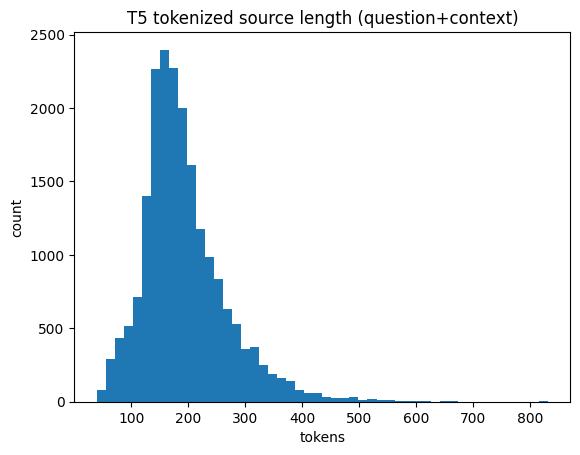

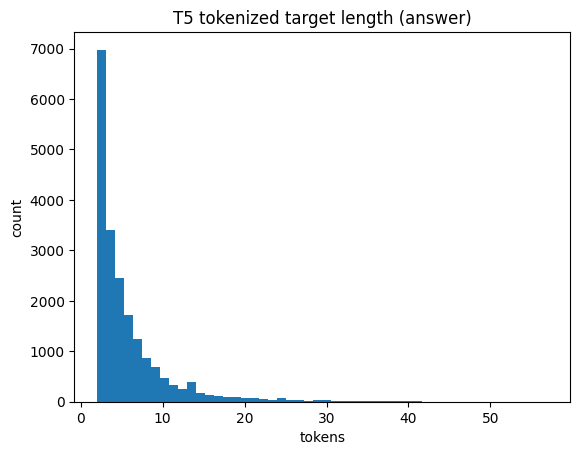

In [7]:
# %%
# Choose tokenizers
t5_name = 't5-base'              # good for text-to-text demos
gpt2_name = 'gpt2-medium'                # medium GPT-2

t5_tok = AutoTokenizer.from_pretrained(t5_name)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)

def qa_lengths(ds: Dataset, tokenizer, max_rows: int = 5000):
    rows = min(len(ds), max_rows)
    src_lens, tgt_lens = [], []
    for i in range(rows):
        ex = ds[i]
        src_text = f"question: {ex['question'].strip()}  context: {ex['context'].strip()}"
        tgt_text = ex['answers']['text'][0] if len(ex['answers']['text']) else ''
        src_lens.append(len(tokenizer(src_text).input_ids))
        tgt_lens.append(len(tokenizer(tgt_text).input_ids))
    return np.array(src_lens), np.array(tgt_lens)

src_lens_t5, tgt_lens_t5 = qa_lengths(squad_train, t5_tok, max_rows=20000)
src_lens_g2, tgt_lens_g2 = qa_lengths(squad_train, gpt2_tok, max_rows=20000)

def summarize_lens(name, src, tgt):
    def pct(a): 
        return {p:int(np.percentile(a,p)) for p in [50,75,90,95,99]}
    print(f"\n{name} — source lengths percentiles:", pct(src))
    print(f"{name} — target lengths percentiles:", pct(tgt))

summarize_lens('T5', src_lens_t5, tgt_lens_t5)
summarize_lens('GPT-2', src_lens_g2, tgt_lens_g2)

# Plot (optional)
plt.figure()
plt.hist(src_lens_t5, bins=50)
plt.title('T5 tokenized source length (question+context)')
plt.xlabel('tokens'); plt.ylabel('count')
plt.show()

plt.figure()
plt.hist(tgt_lens_t5, bins=50)
plt.title('T5 tokenized target length (answer)')
plt.xlabel('tokens'); plt.ylabel('count')
plt.show()


In [8]:
# %%
# Based on the printed percentiles above, set conservative defaults.
# If you have a smaller GPU, reduce these (e.g., source 384).

MAX_SOURCE_QA = 512    # Source (question+context) tokens
MAX_TARGET_QA = 32     # Answers in SQuAD are short; 32 tokens is typically ample

print('MAX_SOURCE_QA =', MAX_SOURCE_QA)
print('MAX_TARGET_QA =', MAX_TARGET_QA)


MAX_SOURCE_QA = 512
MAX_TARGET_QA = 32


We’ll work with a modest SQuAD subset so everything runs smoothly on shared hardware. That’s perfect for learning the workflow and comparing strategies. Treat absolute numbers as illustrative; the *direction* of change is the lesson.

In [9]:
qa_train = squad_train.select(range(10000))
qa_validation = squad_train.select(range(10000, 11000))
qa_test = squad_validation.select(range(2000))

# cleaning unused data
del squad
del squad_train
del squad_validation
clear_memory()

**What the next helpers do.** These wrappers run generation over a batch of prompts with safe defaults. One is written for encoder–decoder models like T5; the other is for decoder‑only models like GPT‑2. Both enforce our length limits and make it easy to switch between greedy decoding and a small beam without touching the lower‑level details.

In [10]:
import tqdm

@torch.no_grad()
def seq2seq_inference(model, tokenizer, prompts, batch_size=32, max_length=512, max_new_tokens=64):
    """
    Sequence-to-sequence inference function for encoder-decoder models.
    """
    model.eval()
    model.config.use_cache = True
    device = next(model.parameters()).device
    preds = []

    for i in tqdm.tqdm(range(0, len(prompts), batch_size)):
        batch = prompts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors='pt', padding=True, truncation=True,
                        pad_to_multiple_of=8, max_length=max_length).to(device)
        
        with torch.inference_mode():
            out = model.generate(
                **enc,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                use_cache=True,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
                return_dict_in_generate=False
            )
        preds.extend(tokenizer.batch_decode(out, skip_special_tokens=True))
    return preds

@torch.no_grad()
def clm_inference(model, tokenizer, prompts, batch_size=32, max_length=512, max_new_tokens=64):
    """
    Inference function for decoder-only models (causal language models).
    """
    model.eval()
    model.config.use_cache = True           # KV cache
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"         # best for decoder-only generation
    device = next(model.parameters()).device
    preds = []

    for i in tqdm.tqdm(range(0, len(prompts), batch_size)):
        batch = prompts[i:i+batch_size]
        enc = tokenizer(
            batch, return_tensors="pt",
            padding=True, pad_to_multiple_of=8,   # tensor-core friendly
            truncation=True, max_length=max_length
        ).to(device)

        with torch.inference_mode():
            out = model.generate(
                **enc,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                use_cache=True,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
                return_dict_in_generate=False
            )

        # slice off the prompt to keep only newly generated tokens
        gen_only = out[:, enc["input_ids"].shape[1]:]
        texts = tokenizer.batch_decode(gen_only, skip_special_tokens=True)
        preds.extend([t.strip() for t in texts])
    return preds

Once the tokenizer do its job, we can read the outputs of the models and check their answers!

When we decode model outputs back to text, we strip any echoed prompt and keep only the answer. The evaluation scripts compare clean strings, so keeping outputs tidy is worth the small effort.

In [11]:
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
answers = seq2seq_inference(t5, t5_tok, ["question: What was the capital of France in 1950?  context: France is a country in Europe."])
answers[0]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


'Paris'

In [12]:

# we should clean the memory after we finished using the model
del t5
clear_memory()

For the SQUAD dataset, we will be meassuring performance using two metrics:

**Exact Match (EM)** - This strict metric assigns a score of 1 if the model’s prediction matches one of the ground-truth answers exactly after normalising case and punctuation, and 0 otherwise. Even a single character difference leads to a score of 0.

**F1 Score** - This is the harmonic mean of precision and recall over the tokens in the predicted and reference answers. F1 rewards partial overlap; it ranges from 0 (no overlap) to 1 (perfect match).

*Example.* Suppose the reference answers are `["water", "water bodies"]` and the model predicts `"water"`. The prediction matches one reference exactly, so EM = 1. Token overlap with "water bodies" yields precision = 1/1 and recall = 1/2, giving F1 = 2×(1/1×1/2)/(1/1+1/2)=0.67.

We’ll use the SQuAD scorer provided through the `evaluate` library. It implements the canonical script used in the literature, including the usual text normalization, so our numbers are comparable and sensible out of the box.

Note: We only take the first answer as the expected answer for simplicity. Some answer lists are repeated, but in reality, there might be more than a possible answer for a question. 

In [13]:
squad_metric = evaluate.load('squad')
def evaluate_qa(predictions, references):
    """Format predictions and references for the SQuAD metric.

    Supports references provided as:
    - list of strings (multiple gold answers)
    - dict with keys 'text' and 'answer_start'
    - dict with key 'answers' containing the above
    - single string
    """
    formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
    formatted_refs = []
    for i, ref in enumerate(references):
        if isinstance(ref, dict) and "answers" in ref:
            answers = ref["answers"]
        elif isinstance(ref, dict) and ("text" in ref and "answer_start" in ref):
            answers = ref
        elif isinstance(ref, str):
            answers = {"text": [ref], "answer_start": [0]}
        else:
            # assume iterable of strings
            texts = list(ref)
            answers = {"text": texts, "answer_start": [0] * len(texts)}
            
        formatted_refs.append({"id": str(i), "answers": answers})
    return squad_metric.compute(predictions=formatted_preds, references=formatted_refs)

### Exercise: Let's try QA prompting!

Now that we can generate answers and evaluate them, let’s try a couple of prompt wordings and decoding settings. Keep the format stable and change just one thing at a time so differences are meaningful.

Add at least one new entry to the `qa_prompt_strategies` dictionary. We challenge you to beat the *minimal* strategy!

In [14]:
qa_prompt_strategies = {
    'minimal': lambda question, context: f"question: {question} context: {context} answer:",
    'instruction': lambda question, context: f'Given the context:\n\n"{context}"\n\nAnswer the following question:\n\n"{question}"\nAnswer:',
    # Add your own strategies here.
}

def apply_qa_prompt_strategy(strategy_name, dataset) -> Tuple[List[str], List[str]]:
    """
    Apply the specified prompt strategy to the dataset.

    Returns:
        A tuple containing the list of prompts and the list of reference answers.
    """
    if strategy_name in qa_prompt_strategies:
        prompt_func = qa_prompt_strategies[strategy_name]
        prompts = [prompt_func(sample['question'], sample['context']) for sample in dataset]
        references = [sample['answers']['text'] for sample in dataset]
        return prompts, references
    else:
        raise ValueError(f"Unknown prompt strategy: {strategy_name}")

You can test visually some answers with the cell below

In [15]:
dataset = qa_validation.select(range(2))

STRATEGY = "minimal"

# Uncomment to test t5
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_tok = AutoTokenizer.from_pretrained(t5_name)

print(f"== strategy '{STRATEGY}' with T5 ==")
prompts, references = apply_qa_prompt_strategy(STRATEGY, dataset)
predictions = seq2seq_inference(t5, t5_tok, prompts)

for prompt, prediction, reference in zip(prompts, predictions, references):
    print(f"Prompt: '{prompt}'")
    print(f"Prediction: '{prediction}'")
    print(f"Reference: '{reference}'",)

scores = evaluate_qa(predictions, references)
print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

del t5, t5_tok
clear_memory()

# Uncomment to test GPT-2
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)

print(f"== strategy '{STRATEGY}' with GPT-2 ==")
prompts, references = apply_qa_prompt_strategy(STRATEGY, dataset)
predictions = clm_inference(gpt2, gpt2_tok, prompts)

for prompt, prediction, reference in zip(prompts, predictions, references):
    print(f"Prompt: '{prompt}'")
    print(f"Prediction: '{prediction}'")
    print(f"Reference: '{reference}'")

scores = evaluate_qa(predictions, references)
print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

== strategy 'minimal' with T5 ==


100%|██████████| 1/1 [00:00<00:00, 14.25it/s]

Prompt: 'question: Along with anxiety, what is an example of directionless emotion? context: The word "emotion" dates back to 1579, when it was adapted from the French word émouvoir, which means "to stir up". The term emotion was introduced into academic discussion to replace passion. According to one dictionary, the earliest precursors of the word likely dates back to the very origins of language. The modern word emotion is heterogeneous In some uses of the word, emotions are intense feelings that are directed at someone or something. On the other hand, emotion can be used to refer to states that are mild (as in annoyed or content) and to states that are not directed at anything (as in anxiety and depression). One line of research thus looks at the meaning of the word emotion in everyday language and this usage is rather different from that in academic discourse. Another line of research asks about languages other than English, and one interesting finding is that many languages have a

== strategy 'minimal' with GPT-2 ==


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

Prompt: 'question: Along with anxiety, what is an example of directionless emotion? context: The word "emotion" dates back to 1579, when it was adapted from the French word émouvoir, which means "to stir up". The term emotion was introduced into academic discussion to replace passion. According to one dictionary, the earliest precursors of the word likely dates back to the very origins of language. The modern word emotion is heterogeneous In some uses of the word, emotions are intense feelings that are directed at someone or something. On the other hand, emotion can be used to refer to states that are mild (as in annoyed or content) and to states that are not directed at anything (as in anxiety and depression). One line of research thus looks at the meaning of the word emotion in everyday language and this usage is rather different from that in academic discourse. Another line of research asks about languages other than English, and one interesting finding is that many languages have a

Add your strategy, then run the cell below to evaluate all defined strategies on the validation set. Skim a few outputs to see what the model is doing—do names and numbers survive the trip into the target language?

In [16]:
dataset = qa_validation

print("=   Evaluating T5   =")
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_tok = AutoTokenizer.from_pretrained(t5_name)
for strategy_name in qa_prompt_strategies.keys():
    print(f"== strategy '{strategy_name}' ==")
    prompts, references = apply_qa_prompt_strategy(strategy_name, dataset)
    predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=64)
    scores = evaluate_qa(predictions, references)
    print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

del t5
clear_memory()

print("\n=   Evaluating GPT-2   =")
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)
for strategy_name in qa_prompt_strategies.keys():
    print(f"== strategy '{strategy_name}' ==")
    prompts, references = apply_qa_prompt_strategy(strategy_name, dataset)
    predictions = clm_inference(gpt2, gpt2_tok, prompts, batch_size=64)
    scores = evaluate_qa(predictions, references)
    print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

del gpt2
clear_memory()

=   Evaluating T5   =
== strategy 'minimal' ==


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


-> EM: 57.3 F1: 63.72726161519638

== strategy 'instruction' ==


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


-> EM: 0.2 F1: 0.2168929110105581


=   Evaluating GPT-2   =
== strategy 'minimal' ==


100%|██████████| 16/16 [00:37<00:00,  2.34s/it]


-> EM: 0.0 F1: 5.165764101120821

== strategy 'instruction' ==


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


-> EM: 0.0 F1: 6.418160333476867



Pick your best strategy and run it on the **test split**. Keep the prompt text handy—we’ll reuse the same format after fine‑tuning so our comparison stays fair.

In [18]:
dataset = qa_test
BEST_STRATEGY = 'minimal'

print(f"=   Evaluating T5 with strategy {BEST_STRATEGY} on Test! =")
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_tok = AutoTokenizer.from_pretrained(t5_name)
prompts, references = apply_qa_prompt_strategy(BEST_STRATEGY, dataset)
predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=64)
scores = evaluate_qa(predictions, references)
print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

del t5
clear_memory()

print(f"=   Evaluating GPT-2 with strategy {BEST_STRATEGY} on Test! =")
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)
prompts, references = apply_qa_prompt_strategy(BEST_STRATEGY, dataset)
predictions = clm_inference(gpt2, gpt2_tok, prompts, batch_size=64)
scores = evaluate_qa(predictions, references)
print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')

del gpt2
clear_memory()

=   Evaluating T5 with strategy minimal on Test! =


100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


-> EM: 59.4 F1: 63.12455129894259

=   Evaluating GPT-2 with strategy minimal on Test! =


100%|██████████| 32/32 [01:23<00:00,  2.59s/it]


-> EM: 0.0 F1: 5.70529276410452



It is not a coincidence that minimal got a good performance for **T5** out of the box. The **T5** model was trained on many instructions and NLP tasks, like Question Answering (although not specifically in SQUAD). It seems this prompting strategy is very much present in its base training. 

Short, well‑labeled prompts often work nicely with encoder–decoder models like **T5**, which read the input fully and write a concise output. Decoder‑only models can also do well here, but they often benefit more from a short, targeted fine‑tuning step on the task.

### Fine-tuning GPT-2

Fine-tuning an LLM is the process of teaching it on an specific task. This is usually done for preparing an LLM to perform well on a downstream task. The process is very much alike the one for pretraining them, albeit with a much smaller dataset. This means that the model is going to get biased to the specific task, and many times we will see its performance decreasing on other tasks. This phenomenon is called Catastrofic Forgetting, and still have no known cure. We will discuss this a bit more later in the session.


Fine‑tuning means taking a general model and nudging it toward our task with labeled examples. We keep the same prompt style—context and question followed by “Answer:” —and train the model so that the part it learns to write is just the answer text. This focuses learning on what matters and keeps inference simple.

In [19]:
from trl import SFTTrainer, SFTConfig

To fine‑tune GPT‑2, we first prepare the tokenizer and preprocess the data properly. We build prompt‑answer pairs and set the tokenizer to pad on the right. This ensures the model sees the prompt and answer in the correct order and that batches align neatly.

In [20]:

gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)
gpt2_tok.padding_side = "right"
gpt2_tok.pad_token = gpt2_tok.eos_token

Then, we prepare the data for ingesting to the training loop.

For `SFTTrainer` to work, we need to properly separate prompts and completions (being completions our expected answers to questions). We apply the function to both training and validation datasets and filter out any with an empty completion to avoid errors.

In [21]:
# --- make a prompt-completion view of SQuAD ---
def to_prompt_completion(batch):
    prompts, completions = [], []
    for q, c, a in zip(batch["question"], batch["context"], batch["answers"]):
        gold = a["text"][0] if a["text"] else ""
        if not gold.strip():          # filter empties (prevents labelless samples)
            gold = ""                 # keep or skip; we skip below
            
        prompts.append(f"question: {q} context: {c}")
        completions.append(" " + gold)
    return {"prompt": prompts, "completion": completions}

train_pc = qa_train.map(
    to_prompt_completion, batched=True,
    remove_columns=qa_train.column_names,
    desc="Building prompt-completion (train)"
)
valid_pc = qa_validation.map(
    to_prompt_completion, batched=True,
    remove_columns=qa_validation.column_names,
    desc="Building prompt-completion (valid)"
)

# Filter truly empty completions (no supervised tokens)
def nonempty(ex): return len(ex["completion"].strip()) > 0
train_pc = train_pc.filter(nonempty, desc="Filter empty completions (train)")
valid_pc = valid_pc.filter(nonempty, desc="Filter empty completions (valid)")


But why do we need to have prompts and completions separated?

When we train in Causal Language Modelling, the trainer basically takes the input tokens, shift them to the right by one position, and use them for evaluating the prediction capacity of the model. This prediction distribution is matched against the expected distribution by computing a loss function. 

However, how much of that distribution is our actual target? We saw that most of the input (question + context) were around 300 tokens, while the expected answer tokens were less than 10 in its majority. This means that if we compute the loss function with all the sequence, the input sequence will be dominating the loss computation and probably diminishing the gains from fine-tuning.

In the code below, we set the training parameters, like the `batch size`, `learning rate`, and there is a `completion_only_loss` parameter that targets this specific problem, and it is already implemented!

In [22]:
cfg = SFTConfig(
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    max_grad_norm=1.0,
    seed=SEED,

    # Efficiency
    group_by_length=True,       # minimize padding in each batch

    # Precision / memory
    gradient_checkpointing=True,

    # Forward to from_pretrained (disable cache during training)
    model_init_kwargs={"use_cache": False},

    # make completion-only explicit; it’s default for prompt-completion
    completion_only_loss=True,

    # Logging & eval
    report_to=[],
    run_name=None,
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=200,

    save_strategy="steps",
    save_steps=400,
    save_total_limit=1,             # keep only {best, most recent}
    load_best_model_at_end=True    # after training, load the best checkpoint
)

trainer = SFTTrainer(
    model=gpt2_name,
    args=cfg,
    train_dataset=train_pc,          # expects columns: "prompt", "completion"
    eval_dataset=valid_pc,
    processing_class=gpt2_tok,            # <-- pass tokenizer here
)
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
200,0.842100,0.709239,2.556895,1139695.000000,0.828394
400,0.613200,0.618537,2.494343,2312402.000000,0.843151
600,0.542100,0.579403,2.420723,3458994.000000,0.850641
800,0.509800,0.558452,2.294940,4610184.000000,0.856891
1000,0.439100,0.563348,2.245056,5751667.000000,0.856759
1200,0.437200,0.556084,2.258068,6890743.000000,0.854903


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1252, training_loss=0.6525307459572253, metrics={'train_runtime': 544.8684, 'train_samples_per_second': 73.412, 'train_steps_per_second': 2.298, 'total_flos': 1.3563644621684736e+16, 'train_loss': 0.6525307459572253, 'entropy': 2.385621428489685, 'num_tokens': 7152692.0, 'mean_token_accuracy': 0.9049517214298248, 'epoch': 4.0})

Now, lets see if this tuned model really learned something

### After training

Run the same evaluation as before. If EM and F1 improved, open a few examples to see how. Do answers look more concise? Are fewer getting cut off? Keep one or two before/after examples—we’ll revisit them in the wrap‑up.

In [23]:

print(f"=   Evaluating fine-tuned GPT-2 with strategy '{BEST_STRATEGY}' on Test! =")
gpt2 = trainer.model.eval()
gpt2_tok = trainer.processing_class
prompts, references = apply_qa_prompt_strategy(BEST_STRATEGY, dataset)
predictions = clm_inference(gpt2, gpt2_tok, prompts)
scores = evaluate_qa(predictions, references)
print(f"-> EM: {scores['exact_match']} F1: {scores['f1']}", end='\n\n')


=   Evaluating fine-tuned GPT-2 with strategy 'minimal' on Test! =


100%|██████████| 63/63 [00:36<00:00,  1.74it/s]


-> EM: 58.55 F1: 67.71997057461992



In [24]:
del trainer
clear_memory()

Great, it seems **GPT-2** now understand the task a lot better and improved its performance over 10 times! Now it is comparable to base **T5** with the prompting strategy 'minimal'.

We’ve now guided a general model with a clear prompt and tuned it so it answers questions more reliably. Let’s apply the same workflow to translation: start with a simple prompt, see what we get, and then fine‑tune a model to translate English to Spanish more consistently.

# Part B — Machine Translation (English→Spanish on OPUS‑100)

We now examine **machine translation** with **t5-base** and **GPT-2-medium** and see how these models behave in this task.


Let’s look at a few English–Spanish pairs to get a feel for length, tone, and named entities that must be preserved.

In [25]:
# %%
# Load OPUS-100 English-Spanish. The full dataset is large; we will sample for class runtime.
opus = load_dataset('Helsinki-NLP/opus-100', 'en-es')
opus

opus_train = opus['train'].shuffle()
opus_validation = opus['validation'].shuffle()
opus_test = opus['test'].shuffle()

README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/237k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/238k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
peek(opus_train)
peek(opus_validation)

{
  "translation": {
    "en": "What measures exist to prevent their forgery etc?",
    "es": "¿Qué medidas existen para evitar su falsificación, etc.?"
  }
}
{
  "translation": {
    "en": "- Cries.",
    "es": "- Gritos."
  }
}
{
  "translation": {
    "en": "If only we can get down to them.",
    "es": "Si tan solo pudiéramos bajar."
  }
}
{
  "translation": {
    "en": "Okay, that bitch is dead.",
    "es": "Okay, esa perra esta muerta."
  }
}


Translated sentences are naturally longer than short QA answers. We’ll repeat the length check for English sources and Spanish targets and set comfortable caps so we do not cut off translations. As before, aim for the upper part of the observed distribution.


T5 source (en) lengths percentiles: {50: 9, 75: 16, 90: 31, 95: 43, 99: 71}
T5 target (es) lengths percentiles: {50: 18, 75: 33, 90: 69, 95: 98, 99: 161}

GPT-2 source (en) lengths percentiles: {50: 9, 75: 16, 90: 31, 95: 43, 99: 71}
GPT-2 target (es) lengths percentiles: {50: 14, 75: 26, 90: 56, 95: 80, 99: 132}


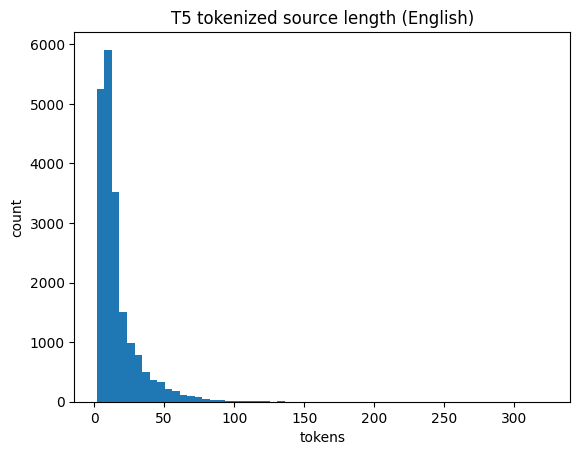

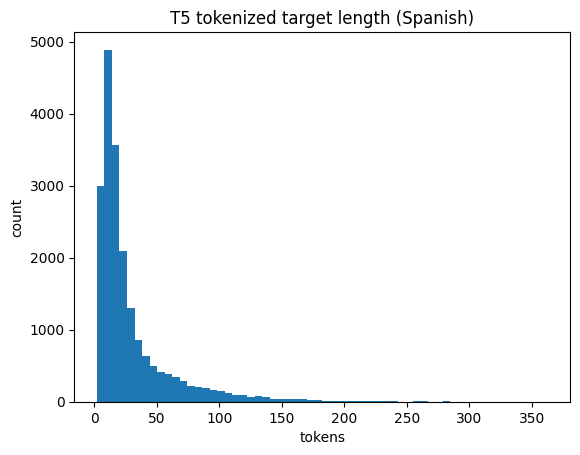

In [27]:
# %%
t5_name = 't5-base'              # good for text-to-text demos
gpt2_name = 'gpt2-medium'                # medium GPT-2

t5_tok = AutoTokenizer.from_pretrained(t5_name)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)

def mt_lengths(ds: Dataset, tokenizer, src_key='en', tgt_key='es', max_rows: int = 20000):
    rows = min(len(ds), max_rows)
    src_lens, tgt_lens = [], []
    for i in range(rows):
        ex = ds[i]['translation']
        src_lens.append(len(tokenizer(ex[src_key]).input_ids))
        tgt_lens.append(len(tokenizer(ex[tgt_key]).input_ids))
    return np.array(src_lens), np.array(tgt_lens)

src_l_mt_t5, tgt_l_mt_t5 = mt_lengths(opus_train, t5_tok, max_rows=20000)
src_l_mt_gpt, tgt_l_mt_gpt = mt_lengths(opus_train, gpt2_tok, max_rows=20000)

def summarize_lens(name, src, tgt):
    def pct(a): 
        return {p:int(np.percentile(a,p)) for p in [50,75,90,95,99]}
    print(f"\n{name} source (en) lengths percentiles:", pct(src))
    print(f"{name} target (es) lengths percentiles:", pct(tgt))

summarize_lens('T5', src_l_mt_gpt, tgt_l_mt_t5)
summarize_lens('GPT-2', src_l_mt_gpt, tgt_l_mt_gpt)

plt.figure()
plt.hist(src_l_mt_t5, bins=60)
plt.title('T5 tokenized source length (English)')
plt.xlabel('tokens'); plt.ylabel('count')
plt.show()

plt.figure()
plt.hist(tgt_l_mt_t5, bins=60)
plt.title('T5 tokenized target length (Spanish)')
plt.xlabel('tokens'); plt.ylabel('count')
plt.show()

In [28]:
# %%
# Based on the printed percentiles above, set conservative defaults.
# If you have a smaller GPU, reduce these (e.g., source 384).

MAX_SOURCE_MT = 128
MAX_TARGET_MT = 256

print('MAX_SOURCE_MT =', MAX_SOURCE_MT)
print('MAX_TARGET_MT =', MAX_TARGET_MT)


MAX_SOURCE_MT = 128
MAX_TARGET_MT = 256


Same as with SQUAD, we will work with subsets of OPUS. 

In [29]:
mt_train = opus_train.select(range(60000))
mt_validation = opus_validation.select(range(2000))
mt_test = opus_test.select(range(2000))

# cleaning unused data
del opus
del opus_train
del opus_validation
del opus_test
clear_memory()

#### Evaluation for Translation

For this session we evaluate QA on the BLEU metric:

**BLEU** - bilingual evaluation understudy (BLEU) score. BLEU computes the geometric mean of modified n-gram precisions between a candidate and one or more reference translations, multiplied by a brevity penalty. Scores lie between 0 and 1, where values closer to 1 indicate closer correspondence to references.

In this notebook, we’ll report **sacreBLEU**, a version of BLEU that standardizes tokenization so scores are comparable and reproducible.

We will make use of the official metric implementations available in Huggingface Evaluate

In [30]:
bleu_metric = evaluate.load('sacrebleu')

def evaluate_bleu(predictions, references):
    """Evaluate BLEU score for translation tasks."""
    return bleu_metric.compute(predictions=predictions, references=references)

### Translation Prompting

Now, just like with Question Answering, we will see how we can use these models without any fine-tuning for Machine Translation. lets try different prompting strategies!

Try adding some prompts to `mt_prompt_strategies` and see what performance you get.

In [31]:
mt_prompt_strategies = {
    'minimal': lambda en_source: f"English: {en_source} Spanish:",
    'minimal_instruction': lambda en_source: f"Translate English to Spanish: {en_source}",
    'instruction': lambda en_source: f'Translate English to Spanish: {en_source}\nTranslation:',
    # Add your own strategies here.
}

def apply_mt_prompt_strategy(strategy_name, dataset) -> Tuple[List[str], List[str]]:
    """
    Apply the specified prompt strategy to the dataset.

    Returns:
        A tuple containing the list of prompts and the list of reference answers.
    """
    if strategy_name in mt_prompt_strategies:
        prompt_func = mt_prompt_strategies[strategy_name]
        prompts = [prompt_func(sample['translation']['en']) for sample in dataset]
        references = [sample['translation']['es'] for sample in dataset]
        return prompts, references
    else:
        raise ValueError(f"Unknown prompt strategy: {strategy_name}")

Test your prompts visually with the cell below

In [32]:
dataset = mt_validation.select(range(2))

STRATEGY = "minimal"

# Uncomment to test t5
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_tok = AutoTokenizer.from_pretrained(t5_name)

print(f"== strategy '{STRATEGY}' with T5 ==")
prompts, references = apply_mt_prompt_strategy(STRATEGY, dataset)
predictions = seq2seq_inference(t5, t5_tok, prompts)

for prompt, prediction, reference in zip(prompts, predictions, references):
    print(f"Prompt: '{prompt}'")
    print(f"Prediction: '{prediction}'")
    print(f"Reference: '{reference}'",)

scores = evaluate_bleu(predictions, references)
print(f"-> BLEU: {scores['score']}", end='\n\n')


# Uncomment to test GPT-2
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)

print(f"== strategy '{STRATEGY}' with GPT-2 ==")
prompts, references = apply_mt_prompt_strategy(STRATEGY, dataset)
predictions = clm_inference(gpt2, gpt2_tok, prompts)

for prompt, prediction, reference in zip(prompts, predictions, references):
    print(f"Prompt: '{prompt}'")
    print(f"Prediction: '{prediction}'")
    print(f"Reference: '{reference}'")

scores = evaluate_bleu(predictions, references)
print(f"-> BLEU: {scores['score']}", end='\n\n')

== strategy 'minimal' with T5 ==


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

Prompt: 'English: If only we can get down to them. Spanish:'
Prediction: 'Wenn wir nur auf sie zugehen können.'
Reference: 'Si tan solo pudiéramos bajar.'
Prompt: 'English: Okay, that bitch is dead. Spanish:'
Prediction: 'Okay, that bitch is dead.'
Reference: 'Okay, esa perra esta muerta.'
-> BLEU: 7.1338676779176575



== strategy 'minimal' with GPT-2 ==


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Prompt: 'English: If only we can get down to them. Spanish:'
Prediction: 'Español

Finnish: Päätä (fi)

French: Père (fr)

German: Pfeil (de)

Italian: Piazza (it)

Polish: Příż (pl)

Port'
Reference: 'Si tan solo pudiéramos bajar.'
Prompt: 'English: Okay, that bitch is dead. Spanish:'
Prediction: 'I'm sorry.

In the episode "The Man Who Wasn't There", the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the character of the'
Reference: 'Okay, esa perra esta muerta.'
-> BLEU: 0.47256291889095237



Add your strategy, then run the cell below to evaluate all defined strategies on the validation set. Skim a few outputs to see what the model is doing (top cell).

In [33]:
dataset = mt_validation

print("=   Evaluating T5   =")
t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
t5_tok = AutoTokenizer.from_pretrained(t5_name)
for strategy_name in mt_prompt_strategies.keys():
    print(f"== strategy '{strategy_name}' ==")
    prompts, references = apply_mt_prompt_strategy(strategy_name, dataset)
    predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=64)
    scores = evaluate_bleu(predictions, references)
    print(scores)
    print(f"-> BLEU: {scores['score']}", end='\n\n')

del t5
clear_memory()

print("\n=   Evaluating GPT-2   =")
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(device)
gpt2_tok = AutoTokenizer.from_pretrained(gpt2_name)
for strategy_name in mt_prompt_strategies.keys():
    print(f"== strategy '{strategy_name}' ==")
    prompts, references = apply_mt_prompt_strategy(strategy_name, dataset)
    predictions = clm_inference(gpt2, gpt2_tok, prompts, batch_size=64)
    scores = evaluate_bleu(predictions, references)
    print(f"-> BLEU: {scores['score']}", end='\n\n')

del gpt2
clear_memory()

=   Evaluating T5   =
== strategy 'minimal' ==


100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


{'score': 3.361462627466688, 'counts': [4560, 1127, 634, 366], 'totals': [34088, 32127, 30166, 28272], 'precisions': [13.377141516076039, 3.5079528122762786, 2.101703905058675, 1.2945670628183361], 'bp': 1.0, 'sys_len': 34088, 'ref_len': 31448}
-> BLEU: 3.361462627466688

== strategy 'minimal_instruction' ==


100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


{'score': 3.698354643371917, 'counts': [4781, 1136, 622, 351], 'totals': [29007, 27021, 25040, 23064], 'precisions': [16.482228427620917, 4.204137522667555, 2.484025559105431, 1.5218522372528616], 'bp': 0.9192914201170537, 'sys_len': 29007, 'ref_len': 31448}
-> BLEU: 3.698354643371917

== strategy 'instruction' ==


100%|██████████| 32/32 [00:25<00:00,  1.28it/s]


{'score': 3.1754750932578806, 'counts': [3941, 1034, 581, 344], 'totals': [32436, 30791, 29151, 27512], 'precisions': [12.150080157849303, 3.35812412718002, 1.9930705636170285, 1.2503634777551613], 'bp': 1.0, 'sys_len': 32436, 'ref_len': 31448}
-> BLEU: 3.1754750932578806


=   Evaluating GPT-2   =
== strategy 'minimal' ==


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


-> BLEU: 0.8773971640611861

== strategy 'minimal_instruction' ==


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]


-> BLEU: 0.5842604651120387

== strategy 'instruction' ==


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]


-> BLEU: 0.4003185845818317



Before looking at scores alone, read a handful of translations. When outputs look off, is it the wrong language, a missing phrase, or a tense mismatch? A short qualitative pass often explains the numbers you see.

**T5** seems to be the best, but both seem underperforming, right? **T5** was actually trained in translation too, so why is it that bad? Lets analyze its responses to see if the model is translating, and if so, to what language.

In [34]:
# %%

from langdetect import detect, DetectorFactory
from langcodes import Language
DetectorFactory.seed = SEED

STRATEGY = "minimal_instruction"

t5 = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to(device)
print(f"== T5 with strategy '{STRATEGY}' ==")
prompts, references = apply_mt_prompt_strategy(STRATEGY, dataset.select(range(5)))
predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=32)

for prompt, reference, prediction in zip(prompts, references, predictions):
    print(f"prompt: '{prompt}'\nreference: '{reference}'\nprediction: '{prediction}'")
    
    try:
        lang_ref = Language.make(detect(reference)).display_name()
    except:
        lang_ref = 'unk'
    try:
        lang_pred = Language.make(detect(prediction)).display_name()
    except:
        lang_pred = 'unk'

    print(f"expected: '{lang_ref}', got: '{lang_pred}'\n")
    
del t5
clear_memory()

== T5 with strategy 'minimal_instruction' ==


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


prompt: 'Translate English to Spanish: If only we can get down to them.'
reference: 'Si tan solo pudiéramos bajar.'
prediction: 'Wenn wir nur auf sie zukommen.'
expected: 'Spanish', got: 'German'

prompt: 'Translate English to Spanish: Okay, that bitch is dead.'
reference: 'Okay, esa perra esta muerta.'
prediction: 'Okay, diese Hündin ist tot.'
expected: 'Spanish', got: 'Afrikaans'

prompt: 'Translate English to Spanish: This is some sort of joke, right?'
reference: 'Esta es una especie de broma, ¿verdad?'
prediction: 'Das ist eine Art Witz, oder?'
expected: 'Spanish', got: 'German'

prompt: 'Translate English to Spanish: Michaelson, can you hear me?'
reference: 'Michaelson, puedes escucharme?'
prediction: 'Michaelson, können Sie mich hören?'
expected: 'Spanish', got: 'German'

prompt: 'Translate English to Spanish: "The ethical and moral responsibilities linked with scientific research can, then, be seen as an internal requirement of science inasmuch as it is a fully human activity, a

It seems that **T5** is translating. However instead of producing spanish it is producing German! This hints us to an important detail about the model pretraining. 

Actually, according to the model [documentation](https://huggingface.co/google-t5/t5-base) we see this:

> Language(s) (NLP): English, French, Romanian, **German**

So, troublesome as it is, Spanish is not a language this model has been trained on. Let us change that.


### Fine‑tune `t5-base` for English→Spanish

We’ll fine‑tune **T5** on our English→Spanish pairs. Each input is the prefixed English sentence; each target is the Spanish reference. A short run is often enough to make outputs more consistent and to reduce off‑target surprises.

In [35]:
t5_ft = AutoModelForSeq2SeqLM.from_pretrained(t5_name)
t5_tok = AutoTokenizer.from_pretrained(t5_name)

For preprocessing, we will build our training prompts (as we want to teach the model to identify the task it ought to solve). We prefix inputs with `translate English to Spanish:` and preproces our dataset.


In [36]:
PREFIX = 'translate English to Spanish: '

def preprocess_mt_t5(examples):
    inputs  = [PREFIX + ex["en"] for ex in examples["translation"]]
    targets = [ex["es"] for ex in examples["translation"]]
    
    # Simpler + recommended: one call with text_target
    model_inputs = t5_tok(
        inputs,
        text_target=targets,
        max_length=MAX_SOURCE_MT,
        truncation=True
    )
    return model_inputs

train_proc = mt_train.map(
    preprocess_mt_t5, batched=True, remove_columns=mt_train.column_names
)
valid_proc = mt_validation.map(
    preprocess_mt_t5, batched=True, remove_columns=mt_validation.column_names
)

data_collator = DataCollatorForSeq2Seq(tokenizer=t5_tok, model=t5_name)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Notice we tokenize before training to keep batches consistent and the training loop simple. The key is that the loss only applies to real target tokens—not padding—so the model learns to write the translation, not special tokens.

Lastly, we can set our training parameters and execute

We use standard seq2seq training arguments and enable `predict_with_generate=True` so validation scores reflect actual generations. Keep the run short; we’re looking for clear, explainable gains, not leaderboard numbers.

In [37]:
args = Seq2SeqTrainingArguments(
    output_dir='t5_mt_en_es',
    
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=4e-4,
    max_grad_norm=1.0,

    lr_scheduler_type="cosine",
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_MT,
    seed=SEED,

    # Efficiency
    group_by_length=True,       # minimize padding in each batch

    # Precision / memory
    gradient_checkpointing=True,

    # Logging & eval
    report_to=[],
    run_name=None,
    logging_strategy="steps",
    logging_steps=200,
    eval_strategy="steps",
    eval_steps=200,
    
    save_strategy="no",
    #save_strategy="steps",
    #save_steps=400,
    save_total_limit=1,             # keep only {best, most recent}
    load_best_model_at_end=True,    # after training, load the best checkpoint
)

trainer = Seq2SeqTrainer(
    model=t5_ft,
    args=args,
    train_dataset=train_proc,
    eval_dataset=valid_proc,
    processing_class=t5_tok,
    data_collator=data_collator,
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
200,1.925400,1.579764
400,1.654500,1.443117
600,1.525900,1.371741
800,1.458100,1.296776
1000,1.374600,1.266505
1200,1.264200,1.254626
1400,1.224400,1.227398
1600,1.199600,1.234246
1800,1.188400,1.195544
2000,1.131500,1.182381


RuntimeError: [enforce fail at inline_container.cc:659] . unexpected pos 438121728 vs 438121620

Now lets see how our tuned model works

Run the same evaluation as before on the test split. If BLEU improves, open a few before/after examples to see what changed. Are we staying in Spanish more reliably?

In [38]:

print(f"=   Evaluating fine-tuned T5 with strategy '{STRATEGY}' on Test! =")
t5 = trainer.model.eval()
t5_tok = trainer.processing_class
prompts, references = apply_mt_prompt_strategy(STRATEGY, dataset)
predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=64)
scores = evaluate_bleu(predictions, references)
print(f"-> BLEU: {scores['score']}", end='\n\n')


=   Evaluating fine-tuned T5 with strategy 'minimal_instruction' on Test! =


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]


-> BLEU: 21.476097211416764



The model improved from approx 3 to 22 in BLEU. A jump from a very low BLEU into the 20s is a healthy sign that fine‑tuning helped. It does not tell the whole though, as proper translation quality meassurement require more complex semantic and pragmatic approaches.

However, we can use our judgement to see wether the translations improved by comparing a few example to the old ones.

In [39]:
# %%

from langdetect import detect, DetectorFactory
from langcodes import Language
DetectorFactory.seed = SEED

STRATEGY = "minimal_instruction"

print(f"== T5 with strategy '{STRATEGY}' ==")
prompts, references = apply_mt_prompt_strategy(STRATEGY, dataset.select(range(5)))
predictions = seq2seq_inference(t5, t5_tok, prompts, batch_size=32)

for prompt, reference, prediction in zip(prompts, references, predictions):
    print(f"prompt: '{prompt}'\nreference: '{reference}'\nprediction: '{prediction}'")
    
    try:
        lang_ref = Language.make(detect(reference)).display_name()
    except:
        lang_ref = 'unk'
    try:
        lang_pred = Language.make(detect(prediction)).display_name()
    except:
        lang_pred = 'unk'

    print(f"expected: '{lang_ref}', got: '{lang_pred}'\n")

== T5 with strategy 'minimal_instruction' ==


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

prompt: 'Translate English to Spanish: If only we can get down to them.'
reference: 'Si tan solo pudiéramos bajar.'
prediction: 'Si sólo podemos irnos a ellos.'
expected: 'Spanish', got: 'Spanish'

prompt: 'Translate English to Spanish: Okay, that bitch is dead.'
reference: 'Okay, esa perra esta muerta.'
prediction: 'Bueno, esa horse está muerta.'
expected: 'Spanish', got: 'Spanish'

prompt: 'Translate English to Spanish: This is some sort of joke, right?'
reference: 'Esta es una especie de broma, ¿verdad?'
prediction: 'Esto es una gluma, verdad?'
expected: 'Spanish', got: 'Spanish'

prompt: 'Translate English to Spanish: Michaelson, can you hear me?'
reference: 'Michaelson, puedes escucharme?'
prediction: 'Michaelson, puedes escucharme?'
expected: 'Spanish', got: 'Spanish'

prompt: 'Translate English to Spanish: "The ethical and moral responsibilities linked with scientific research can, then, be seen as an internal requirement of science inasmuch as it is a fully human activity, and 

We did it! now **T5** knows how to translate somewhat to spanish! a totally new language it was not trained on originally!

In [40]:
del t5_ft, t5, trainer
clear_memory()

## Wrap‑up & what to try next

You’ve now walked the full route twice: meet the data, write a clear prompt, choose sensible decoding, measure what you get, and fine‑tune to improve it. In QA, that meant short, precise answers; in translation, it meant staying in the right language and preserving meaning.

If you want to keep exploring, change the prompt wording and decoding settings and see how tone and accuracy shift. Try a multilingual checkpoint and compare off‑target behavior. For translation, compute chrF alongside BLEU and decide which tells a better story for your sample. Keep a few before/after examples— they make improvements feel real.

## References

- **Stanford Question Answering Dataset (SQuAD)** – A reading‑comprehension dataset where crowdworkers ask questions about Wikipedia articles and answers are spans from the passages. SQuAD 2.0 also includes unanswerable questions.  The dataset is distributed under a CC BY‑SA 4.0 licence.

- **OPUS‑100 multilingual corpus** – An English‑centric corpus covering 100 languages sampled from the OPUS collection.  The dataset is split into training, development and test sets; up to 1 million sentence pairs are sampled per language pair for training and up to 2 thousand pairs for development and test.

- **T5‑Base model** – A 220‑million‑parameter Text‑to‑Text Transfer Transformer which reframes all NLP tasks into a unified text‑to‑text.  The base checkpoint supports English, French, Romanian and German and is released under the Apache 2.0 licence.

- **GPT‑2 (small)** – A causal Transformer language model pretrained on a large corpus of English text to predict the next token.  The 124 M‑parameter version is suitable for downstream fine‑tuning and is distributed with an MIT licence.

- **SacreBLEU** – An evaluation library for machine‑translation research that computes reproducible BLEU, chrF and TER scores. It wraps the WMT BLEU implementation and automatically downloads standard test sets.

- **🤗 Evaluate** – A Hugging Face library providing a unified interface to dozens of evaluation metrics across NLP, computer vision and reinforcement learning tasks.

- **TRL (Transformer Reinforcement Learning)** – A Hugging Face library offering tools for post‑training transformer models, including Supervised Fine‑Tuning (SFT) and reinforcement‑learning methods like GRPO and DPO. It integrates closely with the transformers library.

